In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
# Step 2: Enable interactive mode for Jupyter Notebook
%matplotlib inline
np.set_printoptions(formatter={'float_kind': lambda x: f"{x:0.6f}"})

In [2]:
df = pd.read_excel('data6.xlsx')

In [3]:
df

,x1,x2,x3,x4,x5,y,Notes
0,0.447980,0.292394,0.195912,0.770109,0.233985,-0.599003,9/6 grad for #1 exp 1.07
1,0.447980,0.292394,0.195912,0.770109,0.233985,-0.634347,recalculated from 23/6
2,0.447980,0.292394,0.195912,0.770109,0.233985,-0.609845,NaN
3,0.459005,0.128153,0.767479,0.795951,0.000000,-0.492527,9/6 grad for #0 exp 0.62
4,0.459005,0.128153,0.767479,0.795951,0.000000,-0.423076,recalculated from 23/6
...,...,...,...,...,...,...,...
81,0.485939,0.250542,0.557931,0.765201,0.019598,-0.332658,recalculated from 14/7
82,0.332813,0.499164,0.589376,0.999999,0.167226,-0.574088,recalculated from 14/7
83,0.471328,0.241269,0.547809,0.735301,0.080112,-0.373349,recalculated from 14/7
84,0.193848,0.335426,0.445687,0.469502,0.120570,-0.740530,17/7 quad appr exp 0.219


In [4]:
df = df.drop(columns=['Notes'])
df=df.dropna()

In [5]:
df

,x1,x2,x3,x4,x5,y
0,0.447980,0.292394,0.195912,0.770109,0.233985,-0.599003
1,0.447980,0.292394,0.195912,0.770109,0.233985,-0.634347
2,0.447980,0.292394,0.195912,0.770109,0.233985,-0.609845
3,0.459005,0.128153,0.767479,0.795951,0.000000,-0.492527
4,0.459005,0.128153,0.767479,0.795951,0.000000,-0.423076
...,...,...,...,...,...,...
81,0.485939,0.250542,0.557931,0.765201,0.019598,-0.332658
82,0.332813,0.499164,0.589376,0.999999,0.167226,-0.574088
83,0.471328,0.241269,0.547809,0.735301,0.080112,-0.373349
84,0.193848,0.335426,0.445687,0.469502,0.120570,-0.740530


# Visualise data on plots

In [6]:
# two highest points in top_2_indices will have color in red
top_2_indices = df['y'].nlargest(2).index
top_qntl_index = df['y'].nlargest(6).index
colors = np.full(df.shape[0], 'b', dtype=object)  # Default color is blue
colors[top_qntl_index] = 'y'
colors[top_2_indices] = 'r'  # Color top points red

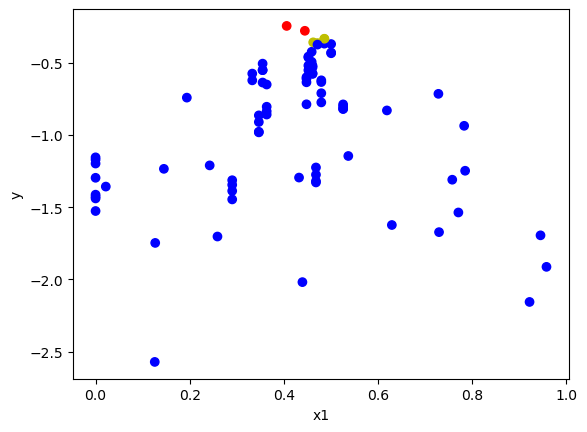

In [7]:
plt.scatter(df['x1'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x1')
plt.show()

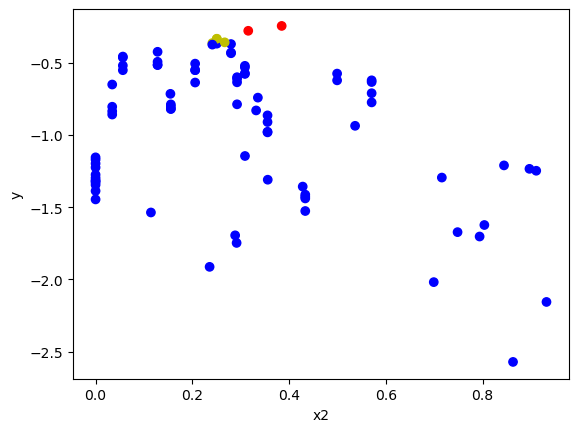

In [8]:
plt.scatter(df['x2'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x2')
plt.show()

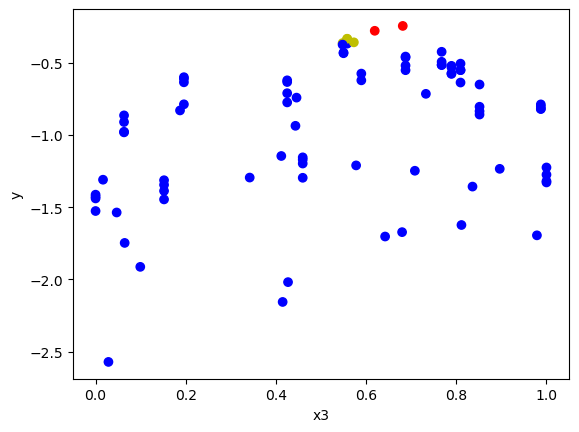

In [9]:
plt.scatter(df['x3'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x3')
plt.show()

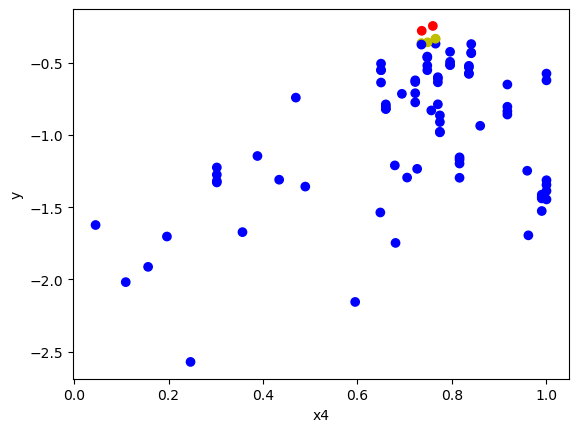

In [10]:
plt.scatter(df['x4'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x4')
plt.show()

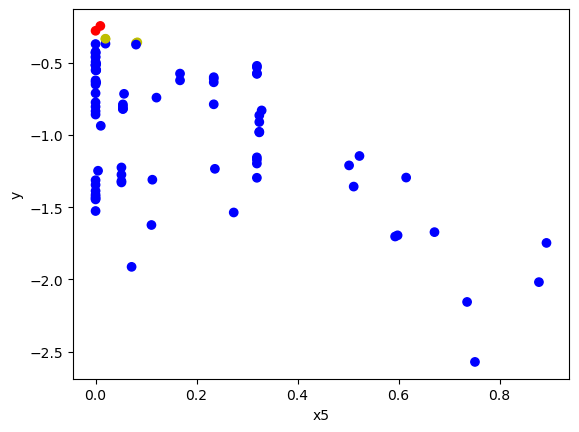

In [11]:
plt.scatter(df['x5'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x5')
plt.show()

# You can rotate in 3 dimentions

<IPython.core.display.Javascript object>


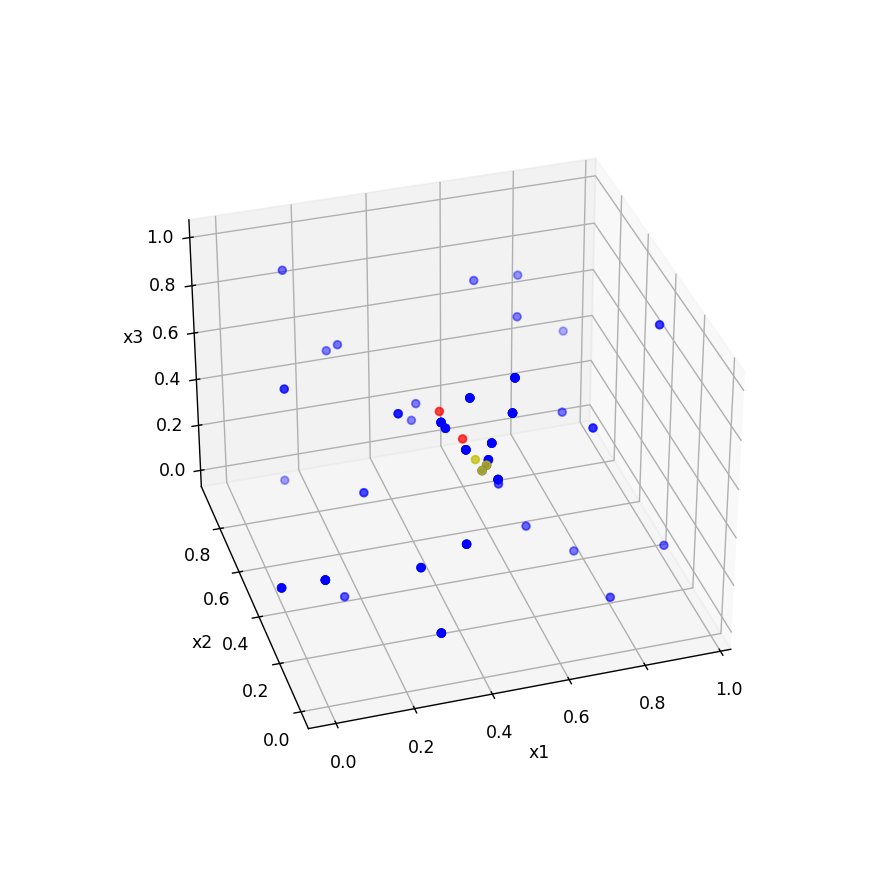

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
ax.scatter(df['x1'], df['x2'], df['x3'], c = colors)
# Set labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
# Display the plot
plt.show()

In [13]:
%matplotlib inline

# 3. Build the grid for Optimization
fine tune the size of grid for high dimention!

In [14]:
x = np.linspace(0,0.999999,20).reshape(-1,1)

In [15]:
x_grid = np.array([[x1, x2, x3, x4, x5] for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x ])

In [16]:
x_grid = x_grid.squeeze()

In [17]:
X = df.iloc[:,:-1].to_numpy()

In [18]:
y = df.iloc[:,-1].to_numpy()

# 4. Use Gaussian Process Regressor with Radial Based Function and WhiteKernel (because of noise)

In [34]:
kernel = RBF(length_scale = 0.5, length_scale_bounds=(1e-3 , 1e3)) + \
    WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-10, 1e1))
bo_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=1000, normalize_y=True)
bo_model.fit(X, y)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=0.5) + WhiteKernel(noise_level=0.02),
                         n_restarts_optimizer=1000, normalize_y=True)

In [35]:
# Check that predicted values are equal originals - this is just a control point
# np.column_stack( (y,bo_model.predict(X)) )

In [36]:
bo_model.kernel_

RBF(length_scale=0.512) + WhiteKernel(noise_level=0.0132)

In [37]:
# Predict for the grid
post_mean, post_std = bo_model.predict(x_grid, return_std=True)

In [38]:
# Define aquiring function
a_fun = post_mean + 2 * post_std

In [39]:
# Find the index and maximum value of acquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Bayesian Optimization is',x_grid[i])

The maximum of acquiring function is -0.1494114487958499 the max index is 159999
post_mean = -1.0567653773315464  post_std = 0.45367696426784826
the next point for Bayesian Optimization is [0.000000 0.999999 0.999999 0.999999 0.999999]


In [40]:
from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 2 * post_std)
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*5, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value -0.149411
at point [0.000000 0.999999 0.999999 0.999999 0.999999]


In [41]:
y[top_2_indices[0]]

-0.243899474830149

In [42]:
np.linalg.norm(result.x - X[top_2_indices[0]])

1.2977074842779477

# Use Second attempt for Gaussian Process Regressor with Radial Based Function and WhiteKernel to predict the second maximum

In [43]:
kernel = RBF(length_scale = 0.5, length_scale_bounds=(1e-3 , 1e3)) + \
    WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-10, 1e1))
bo_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=1000, normalize_y=True)
bo_model.fit(X, y)

# Define acquiring function
a_fun = post_mean + 1 * post_std

# Find the index and maximum value of acquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Bayesian Optimization is',x_grid[i])

bo_model.predict([x_grid[i]])

from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 1 * post_std)
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*5, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

The maximum of acquiring function is -0.24706795172116874 the max index is 1332682
post_mean = -0.31104644299400164  post_std = 0.0639784912728329
the next point for Bayesian Optimization is [0.421052 0.315789 0.578947 0.736841 0.105263]
Optimal value -0.244486
at point [0.432395 0.328337 0.594178 0.751730 0.123437]


In [44]:
bo_model.kernel_

RBF(length_scale=0.512) + WhiteKernel(noise_level=0.0132)

In [45]:
np.linalg.norm(result.x - X[top_2_indices[0]])

0.1565449155163099

# Aproximate by quadratic polinome at max point

In [46]:
# Auxiliary function, returns number of needed point to build the plain in n dimention 
def num_of_nonl_param(n):
    # function returns the number of minimum points for quadratic polynomal
    n = np.array(n)
    return int(1 + 2 * n + n * (n-1) / 2)

In [47]:
poly = PolynomialFeatures(2, include_bias = False)
XN = poly.fit_transform(X)

In [48]:
max_index=np.argmax(y) 
max_value = y[max_index]
#print('max value =', max_value)
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)

In [49]:
def apprF(n):
    # Sort the distances and get the indices of the two closest neighbors (excluding itself)
    # THE NUMBER OF POINTS IS EQUIAL TO THE TOTAL DIMENTIONALITY!!!
    closest_indices = np.argsort(distances)[1:n]
    # Indices of the three points (max point + two closest neighbors)
    indices_to_use = np.concatenate(([max_index], closest_indices))
    #print('indices to use', indices_to_use)
    # Show overage distance of closest points. Step should not be far away
    print("Average distance",distances[indices_to_use].mean())
    # Extract the points and their corresponding y values
    XN_selected = XN[indices_to_use]
    y_selected = y[indices_to_use]
    # print(X_selected)
    # Fit a linear hyperplane using the selected points
    lreg = LinearRegression()
    lreg.fit(XN_selected, y_selected)
    print("Y,      Prediction, Distance")
    print("Score =",lreg.score(XN_selected,y_selected))
    print("Normlized error =", np.linalg.norm(y_selected - lreg.predict(XN_selected)))
    print(np.column_stack( (y_selected, lreg.predict(XN_selected), distances[indices_to_use]) ))
    return lreg

In [50]:
num_of_nonl_param(5)

21

In [51]:
lreg = apprF(81) #<- Fine tune this number so solution will be stable

Average distance 0.4950144118204785
Y,      Prediction, Distance
Score = 0.961485609277852
Normlized error = 0.7137392449617198
[[-0.243899 -0.376625 0.000000]
 [-0.277632 -0.379616 0.103788]
 [-0.357588 -0.369551 0.185158]
 [-0.334547 -0.411811 0.199327]
 [-0.332658 -0.411811 0.199327]
 [-0.366756 -0.411811 0.199327]
 [-0.433077 -0.442059 0.209382]
 [-0.369476 -0.442059 0.209382]
 [-0.428560 -0.442059 0.209382]
 [-0.362816 -0.390891 0.219589]
 [-0.373349 -0.390891 0.219589]
 [-0.635986 -0.525447 0.251202]
 [-0.505151 -0.525447 0.251202]
 [-0.550061 -0.525447 0.251202]
 [-0.550079 -0.525447 0.251202]
 [-0.513119 -0.534524 0.278278]
 [-0.423076 -0.534524 0.278278]
 [-0.515221 -0.534524 0.278278]
 [-0.492527 -0.534524 0.278278]
 [-0.632509 -0.601318 0.327375]
 [-0.620678 -0.601318 0.327375]
 [-0.709914 -0.601318 0.327375]
 [-0.773613 -0.601318 0.327375]
 [-0.620853 -0.498749 0.331122]
 [-0.574088 -0.498749 0.331122]
 [-0.518340 -0.595795 0.331867]
 [-0.462617 -0.595795 0.331867]
 [-0.456

In [52]:
X0 = X[max_index,:] 

In [53]:
def opt_fun(x):
    polynom = poly.fit_transform(x.reshape(1, -1))
    return -lreg.predict(polynom)

In [54]:
# define bounds as the solution is not stable!
step = 0.9
bnds = []
for i in range(0,len(X0)): bnds.append( (max(X0[i]-step,0), min(X0[i]+step,0.999999)) )
print('Bonds\n', np.array(bnds))

Bonds
 [[0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.909461]]


In [55]:
result = minimize(opt_fun, X0, bounds=bnds, tol=1e-5)

In [56]:
#print(result)

In [57]:
print('The next point is',result.x)
print(f'Estimated value -{result.fun:0.3f}')

The next point is [0.444892 0.383763 0.623153 0.722789 0.126110]
Estimated value -0.328
